# Classifier Trainig

In [1]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import multilabel_confusion_matrix
import scipy.stats as stats
from tqdm import tqdm
from datetime import datetime

# relevant imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import sys, os
IN_COLAB = 'google.colab' in sys.modules

In [2]:
device = "cpu" # default
if torch.cuda.is_available():
    print("CUDA found, lets use it =]")
    device = "cuda:0"

## Read Data

In [3]:
SAMPLE_LEN = 400

samples= {
    '-':  [],
    'UP':  [],
    'DWN': [],
    'FWD': [],
    'BCK': []
}

label_to_OH = {
    '-':   (1., 0., 0., 0., 0.),
    'UP':  (0., 1., 0., 0., 0.),
    'DWN': (0., 0., 1., 0., 0.),
    'FWD': (0., 0., 0., 1., 0.),
    'BCK': (0., 0., 0., 0., 1.)
}

OH_to_label = {v:k for k,v in label_to_OH.items()}

measurement_file = 'measurements_2024_02_02-10_48_48.csv'
if IN_COLAB:
    measurement_file_path = os.path.join('','content', measurement_file)
else:
    measurement_file_path = os. path.join('C:\\', 'Users', 'itaym', 'Documents', 'limudim', 'semester_8', 'robotic_hand_project', 'data_measurements', measurement_file)

with open(measurement_file_path) as infile:
    _ = infile.readline() # skip headers row
    tmp_empty = []
    while(True):
        l = infile.readline().strip()
        if not l:
            break
        dir = l.rsplit(',',1)[-1]
        if dir in ('UP','DWN','BCK','FWD'):
            tmp = []
            for _ in range(SAMPLE_LEN):
                time, accX, accY, accZ, gyroX, gyroY, gyroZ, _ = infile.readline().strip().split(',')
                tmp.append([float(accX), float(accY), float(accZ), float(gyroX), float(gyroY), float(gyroZ)])
            samples[dir].append(tmp)
        else: # dir is '-'
            time, accX, accY, accZ, gyroX, gyroY, gyroZ, _ = l.split(',')
            tmp_empty.append([float(accX), float(accY), float(accZ), float(gyroX), float(gyroY), float(gyroZ)])
            if len(tmp_empty) == SAMPLE_LEN:
                samples['-'].append(tmp_empty)
                tmp_empty = []

# FIXME: remove hard coded labels here
X = torch.tensor(samples['-'] + samples['UP'] + samples['DWN'] + samples['BCK'] + samples['FWD']).to(device)
y = torch.tensor([[label_to_OH['-']]*SAMPLE_LEN for _ in samples['-']] +
                 [[label_to_OH['UP']]*SAMPLE_LEN for _ in samples['UP']] +
                 [[label_to_OH['DWN']]*SAMPLE_LEN for _ in samples['DWN']] +
                 [[label_to_OH['BCK']]*SAMPLE_LEN for _ in samples['BCK']] +
                 [[label_to_OH['FWD']]*SAMPLE_LEN for _ in samples['FWD']]
                 ).to(device)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# X_train = X_train.reshape((*X_train.shape,1))
# X_test  = X_test.reshape((*X_test.shape,1))

## Data Preview

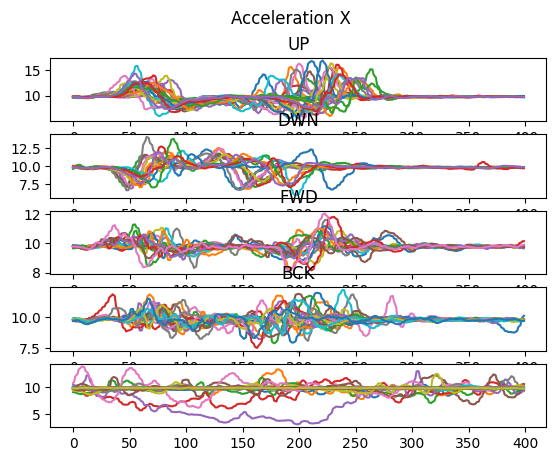

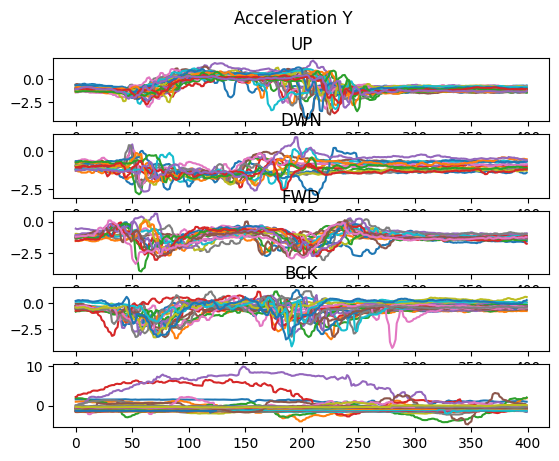

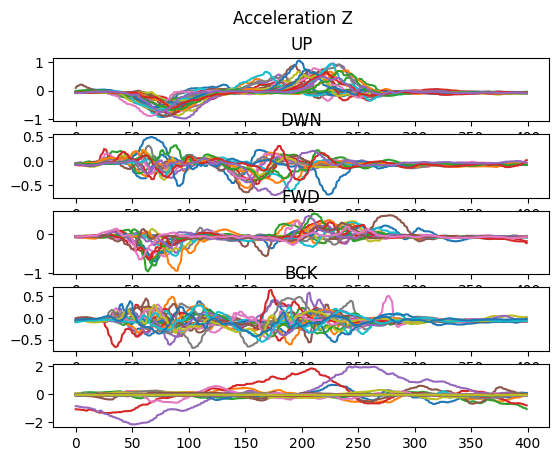

In [4]:
for axes_idx, axes in enumerate(('X','Y','Z')):
    figure = plt.figure()
    figure.suptitle(f'Acceleration {axes}')
    for dir_idx, dir in enumerate(('UP', 'DWN', 'FWD', 'BCK', '-')):
        ax = figure.add_subplot(5,1,dir_idx+1)
        ax.set_title(dir)
        for sam in samples[dir]:
            ax.plot([i[axes_idx+1] for i in sam])

## Define LSTM

In [5]:
class MotionClassifier(nn.Module):

    def __init__(self, num_tags=5, num_features=6, num_hidden=500, num_layers=1):
        super().__init__()
        self.num_tags = num_tags
        self.lstm = nn.LSTM(input_size=num_features, hidden_size=num_hidden, num_layers=num_layers, batch_first=True, dtype=torch.float32)

        # The linear layer that maps from hidden state space to tag space
        self.linear = nn.Linear(num_hidden, num_tags, dtype=torch.float32)
        self.logSoftMax = nn.LogSoftmax(dim=2)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        x = self.logSoftMax(x)
        return x

## Training

In [6]:
model = MotionClassifier().to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=1)

train_rmse_list = []
test_rmse_list = []

if IN_COLAB:
    train_log = open(f'/content/training_{datetime.now().strftime("%Y_%m_%d-%H_%M_%S")}.txt', 'wt')
else:
    train_log = open(f'C:/Users/itaym/Documents/limudim/semester_8/robotic_hand_project/code/ML/training_{datetime.now().strftime("%Y_%m_%d-%H_%M_%S")}.txt', 'wt')

n_epochs = 2000
for epoch in tqdm(range(1,n_epochs+1)):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 10 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = torch.sqrt(loss_fn(y_pred, y_train))
        train_rmse_list.append(train_rmse.to("cpu"))
        y_pred = model(X_test)
        test_rmse = torch.sqrt(loss_fn(y_pred, y_test))
        test_rmse_list.append(test_rmse.to("cpu"))
    print(f"Epoch {epoch}: train RMSE {train_rmse:.4f}, test RMSE {test_rmse:.4f}", file=train_log, flush=True)

train_log.close()

 75%|███████▌  | 1505/2000 [4:20:58<1:25:50, 10.40s/it]    


KeyboardInterrupt: 

In [ ]:
# saving trained model
if IN_COLAB:
    trained_model_path = "/content/trained_model.pt"
else:
    trained_model_path ="C:/Users/itaym/Documents/limudim/semester_8/robotic_hand_project/code/ML/trained_model.pt"
torch.save(model.state_dict(), trained_model_path)

# Evaluate Results

In [ ]:
figure = plt.figure()
figure.suptitle(f'RMSE Over Epoch')
ax = figure.add_subplot(1,1,1)
ax.plot(range(0,2000,10), [i.to("cpu") for i in train_rmse_list], label='train RMSE')
ax.plot(range(0,2000,10), [i.to("cpu") for i in test_rmse_list], label='test RMSE')
ax.legend()

In [ ]:
y_true      = []
y_test_pred = []
# there got to be a better way to do this 😞
with torch.no_grad():
  for i in np.array(y_test.to("cpu")):
    for j in i:
      y_true.append(OH_to_label[tuple(j)])
  
  for i in np.array(np.array(model(X_test).to("cpu"))):
    for j in i:
      y_test_pred.append(OH_to_label[tuple(j)])
  
multilabel_confusion_matrix(y_true, y_test_pred)